<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Models-training" data-toc-modified-id="Models-training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models training</a></span></li><li><span><a href="#Models-analysis" data-toc-modified-id="Models-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models analysis</a></span></li></ul></div>

# Project description: Car price prediction

The used car sales service is developing an app to attract new customers. You can quickly find out the market value of your car. We have historical data at our disposal: technical specifications, specifications and prices of cars. We need to build a model to determine the value. 

To the customer is important:

- the quality of the prediction;
- speed of prediction;
- training time.

**Instruction on how to do the project**.

To strengthen the study, let's go beyond gradient boosting. Let's try simpler models - sometimes they work better.

1. Load and prepare the data.
2. Train different models.
3. Analyse the speed and quality of the models.

**Notes:**

1. To estimate the quality of models, will apply RMSE metric. The value of RMSE metric should be less than 2500.
2. Will master the LightGBM library and use it to build gradient boosting models.
3. Will get the time of execution of a Jupyter Notebook code cell with a special command. As the gradient boosting model can be trained for a long time, let's change only two-three parameters in it.

**Data description**.

*Features*

- `DateCrawled` - date when questionnaire was downloaded from the database
- `VehicleType` - type of vehicle bodywork
- `RegistrationYear` - vehicle registration year
- `Gearbox` - type of gearbox
- `Power` - power (hp)
- `Model` - vehicle model
- `Kilometer` - mileage (km)
- `RegistrationMonth` - vehicle registration month
- `FuelType` - fuel type
- `Brand` - make of car
- `NotRepaired` - if the car has been repaired or not
- `DateCreated` - date of questionnaire creation
- `NumberOfPictures` - number of pictures of the car
- `PostalCode` - postal code of the questionnaire owner (user)
- `LastSeen` - date of the user's last activity

*Target attribute*
- `Price` - price (euros)

In [1]:
# importing required libraries 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

## Data preparation

In [2]:
# data loading and reading

try:
    df = pd.read_csv('autos.csv')
    
except FileNotFoundError:
    df = pd.read_csv('/datasets/autos.csv')

**Data overview**

In [3]:
display(df.sample(5), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
36462,2016-03-31 12:47:37,450,NaN,2016,manual,55,golf,150000,4,NaN,volkswagen,NaN,2016-03-31 00:00:00,0,57462,2016-04-06 05:17:40
28412,2016-04-05 19:36:19,250,small,1999,manual,0,corsa,150000,9,petrol,opel,NaN,2016-04-05 00:00:00,0,48477,2016-04-05 19:36:19
281390,2016-04-04 23:37:11,1700,wagon,1999,auto,170,e_klasse,100000,7,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,82166,2016-04-05 07:42:14
123457,2016-04-03 22:49:49,1050,small,2001,manual,58,corsa,5000,6,petrol,opel,no,2016-04-03 00:00:00,0,51145,2016-04-06 00:45:13
158334,2016-03-06 01:58:47,1690,small,2000,manual,75,2_reihe,150000,12,petrol,peugeot,no,2016-03-06 00:00:00,0,66128,2016-03-10 08:45:40


None

**- Missing values study**

In [4]:
df.isna().agg(['sum','mean']).T.sort_values('mean', ascending=False).style.format({'mean':'{:.2%}'})

,sum,mean
NotRepaired,71154.000000,20.08%
VehicleType,37490.000000,10.58%
FuelType,32895.000000,9.28%
Gearbox,19833.000000,5.60%
Model,19705.000000,5.56%
DateCrawled,0.000000,0.00%
Price,0.000000,0.00%
RegistrationYear,0.000000,0.00%
Power,0.000000,0.00%
Kilometer,0.000000,0.00%


**Conclusion:**

There are 354,369 records and 16 columns in the dataset. Multiple missing entries are observed:

- `NotRepaired`: 71154 out of 354369 (20%)
- `VehicleType`: 37490 out of 354369 (11%)
- `FuelType`: 32895 out of 354369 (9%)
- `Gearbox`: 19833 out of 354369 (6%)
- `Model`: 19705 out of 354369 (6%)

A large number of missing data is ground for checking with the data provider as to the cause and nature of the missing data. In the absence of this possibility, we will try to fill in some of them during the project.

**- Dataset descriptive statistics evaluation**

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Conclusion:**

Many anomalous and strange values are observed:
- `Price`: zero values are present. This is probably not an anomaly, but a reluctance on the part of the client to quote a price.
- `Registration year`: minimum value is 1000 and maximum value 9999
- `Power`: minimum value 0, maximum value 20 000
- `Kilometer`: the values are distributed discretely, more than 50 per cent of the entries have a value of 150,000 km. This column is probably categorical rather than numerical
- `Month of registration`: minimum value is 0
- `No. of pictures`: only null values are present.

Let's analyse the columns with categorical data. 

In [6]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


The most popular make and model of car is - expectedly - the Volkswagen Golf. The most frequently represented cars are those with manual transmission (80%), petrol engine (67%). 

**- checing explicit duplicates**

In [7]:
df.duplicated().sum()

4

There are four full duplicates found in the dataset. Will get rid of them.

In [8]:
df = df.drop_duplicates()
df.shape

(354365, 16)

In [9]:
df.sort_values(by='DateCrawled', ascending=False)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90713,2016-04-07 14:36:58,3500,sedan,1999,manual,143,e_klasse,150000,8,gasoline,mercedes_benz,no,2016-04-07 00:00:00,0,64846,2016-04-07 14:36:58
339649,2016-04-07 14:36:56,8650,suv,1992,manual,121,wrangler,125000,5,petrol,jeep,no,2016-04-07 00:00:00,0,20357,2016-04-07 14:36:56
301030,2016-04-07 14:36:55,15200,wagon,2008,manual,190,a6,150000,9,gasoline,audi,no,2016-04-07 00:00:00,0,81476,2016-04-07 14:36:55
53739,2016-04-07 14:36:54,400,small,1996,manual,60,ibiza,150000,0,NaN,seat,NaN,2016-04-07 00:00:00,0,66299,2016-04-07 14:36:54
204218,2016-04-07 14:36:53,6990,coupe,1979,auto,143,3er,150000,6,petrol,bmw,no,2016-04-07 00:00:00,0,71336,2016-04-07 14:36:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324763,2016-03-05 14:06:24,799,small,1997,manual,60,polo,150000,11,petrol,volkswagen,no,2016-03-05 00:00:00,0,35708,2016-03-09 15:19:01
176823,2016-03-05 14:06:24,6200,convertible,2006,manual,135,megane,90000,9,petrol,renault,no,2016-03-05 00:00:00,0,35764,2016-03-24 09:16:44
99885,2016-03-05 14:06:24,10900,suv,2003,auto,245,NaN,150000,11,petrol,sonstige_autos,no,2016-03-05 00:00:00,0,56072,2016-04-06 22:15:33
220583,2016-03-05 14:06:23,3999,wagon,2003,manual,220,a6,150000,7,petrol,audi,no,2016-03-05 00:00:00,0,57080,2016-03-06 18:29:35


The year of the data upload is 2016. Therefore, later on in the project, this fact will be taken into account when processing outliers for the "RegistrationYear" column.

**- excluding features that are irrelevant and of little value for model learning**

Delete the columns `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen`, `RegistrationMonth`, `PostalCode` as these attributes are uninformative.

In [10]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth', 'PostalCode'], axis=1)

In [11]:
display(df.sample(), df.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
73776,1000,bus,2001,manual,125,zafira,150000,petrol,opel,yes


(354365, 10)

**- filling in the missing values**

In [12]:
# overview of columns with missing values

df.isna().agg(['sum','mean']).T.sort_values('mean', ascending=False).head(5).style.format({'mean':'{:.2%}'})

,sum,mean
NotRepaired,71154.000000,20.08%
VehicleType,37490.000000,10.58%
FuelType,32895.000000,9.28%
Gearbox,19833.000000,5.60%
Model,19705.000000,5.56%


We will fill in the missing values in the `Model` column with the most frequent value in terms of car make and year of registration of the car. Then will fill in the missing values in the column `VehicleType` with the highest-frequency value in terms of the car make and model of the car. Also, fill in the missing values in the column `FuelType` with the highest frequency value by vehicle make and model.

In [13]:
def fillna_with_mode(column, column1, column2):
    '''
    The function takes the names of three columns as arguments:
    1st column in which we fill in the missing values
    2nd and 3rd columns for dataset grouping, on the basis of which we define a mode and fill in
    the missing values with it (if the mode is not a NaN, otherwise fill in the 'Empty' placeholder)
    '''
    
    df[column] = df.groupby([column1, column2])[column]\
    .transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [14]:
fillna_with_mode('Model','Brand','RegistrationYear')
fillna_with_mode('VehicleType','Brand','Model')
fillna_with_mode('FuelType','Brand','Model')

In [15]:
# repalcing placeholder 'Empty' with NaN

df = df.replace('Empty', np.nan)

In [16]:
df.isna().agg(['sum','mean']).T.sort_values('mean', ascending=False).head(5).style.format({'mean':'{:.2%}'})

,sum,mean
NotRepaired,71154.000000,20.08%
Gearbox,19833.000000,5.60%
Model,3442.000000,0.97%
VehicleType,25.000000,0.01%
FuelType,14.000000,0.00%


In a similar way, it does not seem fair to fill in the missing data in the `Gearbox` column, since for the same brand, make and year of registration of the car, the manufacturer may fit both manual and automatic transmissions. The missing values in the `NotRepaired` column also cannot be plausibly filled in based on the available data. Their presence may indicate both that the seller is reluctant to disclose the fact of repair, and that the missing data may indicate the opposite situation - the seller ignores this field, as his car has not been repaired and thus considers this attribute irrelevant for his situation.

For all the remaining missing values, given that they cannot be filled in in the fairest way possible, let's fill them in with the placeholder `'unknown'`.

In [17]:
df = df.fillna('unknown')

In [18]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   NotRepaired       354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


**- changing data type for categorical features**

Since we will be training the model with LightGBM in the course of the project, it has an internal mechanism for processing categorical features, as does Catboost. To work it out, it is enough to change the data type of columns with categorical variables to the corresponding data type - `'category'`. 

In our dataset, the columns with data type `'object'` are categorical data. However, in the course of our study, we determined that the `Kilometer` column with mileage (which has only 13 unique values), should also be attributed to categorical data. The `PostalCode' column is also logically more categorical than numerical.

In [20]:
categorical = df.select_dtypes(include='object').columns

In [21]:
df[categorical] = df[categorical].astype('category')
df['Kilometer'] = df['Kilometer'].astype('category')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             354365 non-null  int64   
 1   VehicleType       354365 non-null  category
 2   RegistrationYear  354365 non-null  int64   
 3   Gearbox           354365 non-null  category
 4   Power             354365 non-null  int64   
 5   Model             354365 non-null  category
 6   Kilometer         354365 non-null  category
 7   FuelType          354365 non-null  category
 8   Brand             354365 non-null  category
 9   NotRepaired       354365 non-null  category
dtypes: category(7), int64(3)
memory usage: 13.5 MB


***Note***: Noting that converting the data type to categorical significantly reduced the memory consumption from 29.7 MB to 13.5 MB. 

**Analysing columns with anomalous values**

**- Column `Price `**

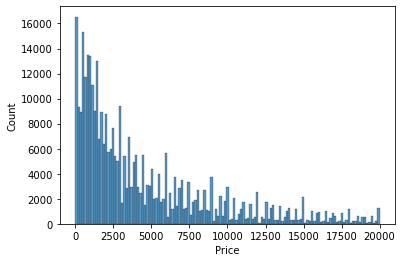

In [23]:
sns.histplot(df['Price']);

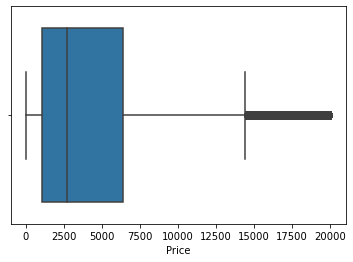

In [24]:
sns.boxplot(df['Price']);

The distribution in the histogram is strongly skewed to the right, with a strong tail. In addition, a clear peak at zero is evident. The boxplot shows the presence of a large number of values outside the right whisker limit. It is difficult to call them anomalies, however, since the maximum value =20000, which fits the logic of the data. The left whisker is zero. It is likely that customers did not specify a value for the car. In order to build the model, price values below 100 euros will be excluded.

**- Column `Power`**

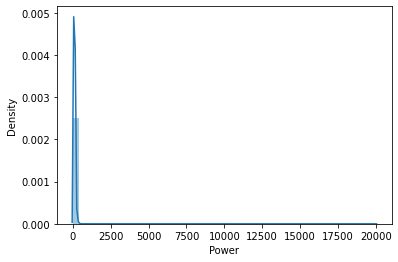

In [25]:
sns.distplot(df['Power']);

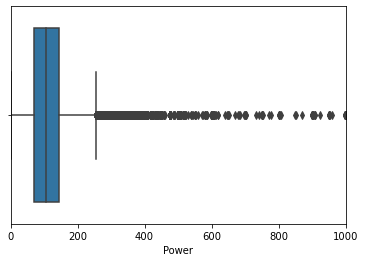

In [26]:
sns.boxplot(df['Power'])
plt.xlim(0, 1000);

The distribution in the histogram is very strongly skewed to the right, with a strong tail. In addition, a clear peak at zero is evident. The boxplot diagram demonstrates the presence of a large number of outliers, which distorts the data very strongly. It should be kept in mind that cars with more than 1,000 hp are very rare and rather belong to the tractor class. It is likely that these values represent an input error. Consequently, unrealistically high values as well as zero values will be processed by changing them to the mean value by the vehicle model.

**- Column `RegistrationYear`**

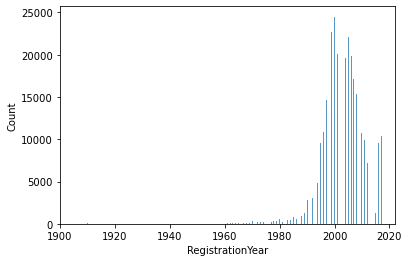

In [27]:
sns.histplot(df['RegistrationYear'])
plt.xlim(1900, 2022);

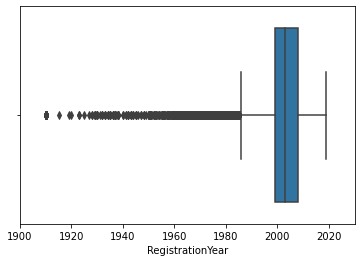

In [28]:
sns.boxplot(df['RegistrationYear'])
plt.xlim(1900, 2030);

In [29]:
df.RegistrationYear.describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

The data is skewed to the left. Lots of odd anomalous values outside the boxplot whiskers, with a year of registration in the future or in the distant past (minimum value is 1000, maximum is 9999). 

Values earlier than 1930 will be deleted. After 1930 it can be assumed that these are retro cars. Therefore, we will keep this data.

The dataset contains cars with a year of registration from the future. The upper range of outliers by Car Registration Year will be the year of the dataset upload. Earlier in the project, we defined the year of data upload as 2016. Consequently, values with the Year of Registration later than 2016 will be excluded from the dataset.

**Handling the anomalous values**

Will exclude observations with a price below EUR 100 from the dataset, which is 3.76% of the total dataset.

In [30]:
len(df.query('Price < 100'))/len(df)

0.03757143058710651

In [31]:
df = df.query('Price > 100')

Will check the number of entries with zero and unrealistic power values.

In [32]:
len(df.query('Power == 0 or Power > 1000'))

34933

Will handle zero values and power values greater than 1,000 hp by replacing them with the mean value by car model:

In [33]:
df.loc[df['Power'] == 0, 'Power'] = df.groupby('Model')['Power'].transform(np.mean)
df.loc[df['Power'] > 1000, 'Power'] = df.groupby('Model')['Power'].transform(np.mean)

Will process the strange values of the Year of Registration of the car. Checking the number of entries with registration year earlier than 1930 and later than 2016 and excluding them from the dataset.

In [34]:
len(df.query('RegistrationYear < 1930 or RegistrationYear > 2016'))

13759

In [35]:
df = df.query('1930 < RegistrationYear < 2017')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326259 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             326259 non-null  int64   
 1   VehicleType       326259 non-null  category
 2   RegistrationYear  326259 non-null  int64   
 3   Gearbox           326259 non-null  category
 4   Power             326259 non-null  float64 
 5   Model             326259 non-null  category
 6   Kilometer         326259 non-null  category
 7   FuelType          326259 non-null  category
 8   Brand             326259 non-null  category
 9   NotRepaired       326259 non-null  category
dtypes: category(7), float64(1), int64(2)
memory usage: 12.5 MB


In [37]:
df.Power = df.Power.astype('int64')

**Conclusion:**.

1. Numerous missing data have been detected in the original dataset:

    - `NotRepaired` - 71154 (20.08%)
    - `VehicleType` - 37490 (10.58%)
    - `FuelType` - 32895 (9.28%)
    - `Gearbox` - 19833 (5.60%)
    - `Model` - 19705 (5.56%)


2. Strange and anomalous values were detected:

    - `Price`: zero values are present. This is probably not an anomaly but a reluctance on the part of the client to indicate a price
    - `Registration year`: minimum value is 1000 and maximum value is 9999
    - `Power`: minimum value - 0, maximum value - 20 000
    - `Kilometreag`': the values are distributed discretely, more than 50 per cent of the entries have a value of 150,000 km. This column is probably categorical rather than numerical
    - `Month of registration`: minimum value is 0
    - `No. of photos`: only zero values are present.


3. Columns `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen`, `RegistrationMonth`, `PostalCode` are deleted as these features are uninformative.


4. Filled in the missing values:

- The missing values in the `Model` column have been filled in with the highest frequency value in terms of car make and year of registration of the car. 
- The missing values in the `VehicleType` and `FuelType` columns were filled in with the highest-frequency value in terms of car make and car model. 
- The remaining missing values, given that they cannot be filled most reasonably, were filled with the placeholder `'unknown'`.


5. After filling in the missing values, strange values (zeros, outliers and unrealistic observations) in the `Price` and `RegistrationYear` columns were discarded.


6. Unrealistic values in the `Power` column have been replaced by model mean values.


## Models training

**- LightGBM Regressor**

We split the sample into training and test samples at a ratio of 3:1, define the target and non-target features, and define a list with categorical features

In [38]:
# defining features and target feature 

X = df.drop(['Price'], axis=1)
y = df['Price']

# splitting dataset into train and test subsets at a proportion 3:1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [39]:
# defining the list of categoric features

categorical_features = ['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']

In [40]:
# initializing the model

lg = lgb.LGBMRegressor(random_state=12345)

**Selecting optimal parameters using GridSearchCV**

In [41]:
lg_param = {'num_leaves' : [200, 300], 
            'n_estimators' : [100, 150], 
            'learning_rate' : [0.01, 0.05, 0.1]}

lg_grid = GridSearchCV(estimator=lg,
                       param_grid=lg_param,
                       scoring='neg_mean_squared_error', cv=3,
                       verbose=10, n_jobs=-1)

lg_grid.fit(X_train, y_train, categorical_feature=categorical_features)

best_estimator_lg = lg_grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [42]:
best_estimator_lg

LGBMRegressor(n_estimators=150, num_leaves=300, random_state=12345)

**Training the model, getting predictions, calculating RMSE, training & prediction time**

In [43]:
%%time

# training model

start = time.time()
best_estimator_lg.fit(X_train, y_train, categorical_feature=categorical_features, verbose=1)
end = time.time()
lg_fit_time = end - start

print('Время обучения_LightGBM, сек. =', lg_fit_time)

Время обучения_LightGBM, сек. = 6.518653392791748
Wall time: 6.52 s


In [44]:
%%time

# getting model predictions

start = time.time()
predictions_lg = best_estimator_lg.predict(X_test)
end = time.time()
lg_predict_time = end - start

print('RMSE_LightGBM =', mean_squared_error(y_test, predictions_lg)**0.5)
print('Время предсказания_LightGBM, сек. =', lg_predict_time)

RMSE_LightGBM = 1523.893948083748
Время предсказания_LightGBM, сек. = 0.9864909648895264
Wall time: 991 ms


We got a rather good result for the quality of the model.

However, to strengthen the study, we will not limit ourselves to just gradient boosting. Let's try simpler models - sometimes they work better. These are rare cases that are easy to miss if we always apply just the boosting.

In [45]:
# creating the list to consolidate RMSE, training and prediction time

results = []

# supplementing the list with the results of LightGBM Regressor

results.append(('LightGBM', lg_fit_time, mean_squared_error(y_test, predictions_lg)**0.5, lg_predict_time))

In [46]:
results

[('LightGBM', 6.518653392791748, 1523.893948083748, 0.9864909648895264)]

Let us investigate the models Linear Regression and Random Forest.

**- Linear Regression**

When working with the LightGBM model, which has an internal mechanism for processing categorical features, we did not have to conduct categorical data encoding. However, for Linear Regression and Random Forest, we need to conduct preliminary transformations of the data, namely categorical features encoding and numerical features scaling.

We will perform categorical features encoding using the One Hot Encoding method.

In [47]:
X = pd.get_dummies(data = X, columns = categorical_features, drop_first=True)

In [48]:
X.head()

,RegistrationYear,Power,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,1993,96,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2011,190,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2001,75,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,69,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The numerical features in the dataset differ in magnitude, units and range. Since the model algorithm may take the differences in values as an element of importance and priority of one feature over another, it is necessary to scale the numerical features.

In order to avoid leakage of the target feature into the test sample, we will set up the object `StandardScaler' and will train it on the training sample. Accordingly, we first split our dataset into training and test samples. 

In [49]:
# splitting dataset into train and test sets at the ratio 3:1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [50]:
# performing scaling of numeric features using StandardScaler

scaler = StandardScaler()

numeric = ['RegistrationYear','Power']

scaler.fit(X_train[numeric])

# transforming train and test sets using transform() function

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [51]:
X_train.head()

,RegistrationYear,Power,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
64974,0.199615,0.052134,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
287849,-0.243492,-0.377401,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
327139,0.199615,-0.171972,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
114458,0.938128,-0.190647,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45374,-0.095790,0.817826,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# initializing the model

lr = LinearRegression()

**Training the model, getting predictions, calculating RMSE, training & prediction time**

In [53]:
%%time

# training the model

start = time.time()
lr.fit(X_train, y_train)
end = time.time()
lr_fit_time = end - start

print('Время обучения_Linear Regression, сек. =', lr_fit_time)

Время обучения_Linear Regression, сек. = 11.219396591186523
Wall time: 11.2 s


In [54]:
%%time

# obtaining model predictions

start = time.time()
predictions_lr = lr.predict(X_test)
end = time.time()
lr_predict_time = end - start

print('RMSE_Linear Regression =', mean_squared_error(y_test, predictions_lr)**0.5)
print('Время предсказания_Linear Regression, сек. =', lr_predict_time)

RMSE_Linear Regression = 2621.9659831715876
Время предсказания_Linear Regression, сек. = 0.24549078941345215
Wall time: 247 ms


In [55]:
# supplementing the list with Linear Regression model results

results.append(('Linear Regression', lr_fit_time, mean_squared_error(y_test, predictions_lr)**0.5, lr_predict_time))

In [56]:
results

[('LightGBM', 6.518653392791748, 1523.893948083748, 0.9864909648895264),
 ('Linear Regression',
  11.219396591186523,
  2621.9659831715876,
  0.24549078941345215)]

**- Random Forest Regressor**

To work with Random Forest, we need to perform a preliminary transformation of the data, namely categorical features encoding and numerical features scaling.

Since the categorical features encoding method One Hot Encoding generates a very large number of additional feature columns in the dataset, this method is not suitable for this model. 

Let us perform categorical features coding using the OrdinalEncoder method.

In [57]:
df[categorical_features].head()

,VehicleType,Gearbox,Model,Kilometer,FuelType,Brand,NotRepaired
0,sedan,manual,golf,150000,petrol,volkswagen,unknown
1,coupe,manual,a4,125000,gasoline,audi,yes
2,suv,auto,grand,125000,gasoline,jeep,unknown
3,small,manual,golf,150000,petrol,volkswagen,no
4,small,manual,fabia,90000,gasoline,skoda,no


In [58]:
# categorical features encoding by OrdinalEncoding method

encoder = OrdinalEncoder()
df[categorical_features] = encoder.fit_transform(df[categorical_features])

In [59]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,4.0,1993,1.0,96,116.0,12.0,6.0,38.0,1.0
1,18300,2.0,2011,1.0,190,29.0,11.0,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,11.0,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,12.0,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,9.0,2.0,31.0,0.0


Scaling numerical features. In order to avoid leakage of the target feature into the test sample, we set up the StandardScaler structure object and train it on the training sample. Accordingly, first we split our dataset into training and test samples.

In [60]:
# defining features and target

X_oe = df.drop(['Price'], axis=1)
y_oe = df['Price']

In [61]:
# splitting dataset into train and test samples at a ratio 3:1

X_oe_train, X_oe_test, y_oe_train, y_oe_test = train_test_split(X_oe, y_oe, test_size=0.25, random_state=12345)

In [62]:
# performing scaling of numeric features using StandardScaler

scaler = StandardScaler()

scaler.fit(X_oe_train[numeric])

# transforming train and test sets using transform() function

X_oe_train[numeric] = scaler.transform(X_oe_train[numeric])
X_oe_test[numeric] = scaler.transform(X_oe_test[numeric])

In [63]:
# initializing the model

rfr = RandomForestRegressor(random_state=12345, n_estimators=100)

**Selecting optimal parameters using GridSearchCV**

In [64]:
rfr_param = {'max_depth': [10, 15], 'min_samples_split': [10, 15]}
    
rfr_grid = GridSearchCV(estimator=rfr,
                            param_grid=rfr_param,
                            scoring='neg_mean_squared_error', cv=3,
                            verbose=10, n_jobs=-1)

rfr_grid.fit(X_oe_train, y_oe_train)

best_estimator_rfr = rfr_grid.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [65]:
best_estimator_rfr

RandomForestRegressor(max_depth=15, min_samples_split=10, random_state=12345)

**Training the model, getting predictions, calculating RMSE, training & prediction time**

In [66]:
%%time

# training model

start = time.time()
best_estimator_rfr.fit(X_oe_train, y_oe_train)
end = time.time()
rfr_fit_time = end - start

print('Время обучения_RFR, сек. =', rfr_fit_time)

Время обучения_RFR, сек. = 55.82750463485718
Wall time: 55.8 s


In [67]:
%%time

# obtaining model predictions

start = time.time()
predictions_rfr = best_estimator_rfr.predict(X_oe_test)
end = time.time()
rfr_predict_time = end - start

print('RMSE_RFR =', mean_squared_error(y_oe_test, predictions_rfr)**0.5)
print('Время предсказания_RFR, сек. =', rfr_predict_time)

RMSE_RFR = 1634.4054325629322
Время предсказания_RFR, сек. = 1.5485765933990479
Wall time: 1.55 s


In [68]:
# supplementing the list with Random Forest Regressor model results

results.append(('Random Forest', rfr_fit_time, mean_squared_error(y_test, predictions_rfr)**0.5, rfr_predict_time))

In [69]:
results

[('LightGBM', 6.518653392791748, 1523.893948083748, 0.9864909648895264),
 ('Linear Regression',
  11.219396591186523,
  2621.9659831715876,
  0.24549078941345215),
 ('Random Forest', 55.82750463485718, 1634.4054325629322, 1.5485765933990479)]

**Feature importance plot**

Will plot the feature importance for the Random Forest model.

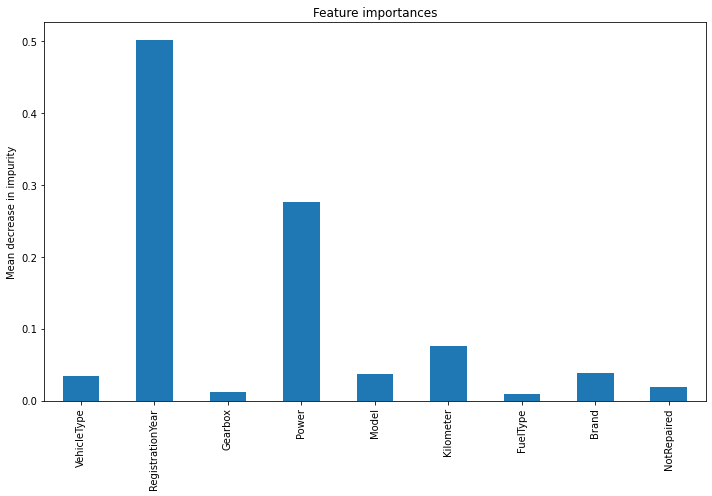

In [70]:
feature_names = X_oe_train.columns 
model = RandomForestRegressor(n_estimators=10, random_state=12345)
model.fit(X_oe_train, y_oe_train)
pred = model.predict(X_oe_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

As can be seen from the graph, the most important features that the Random Forest model identified when predicting target are `RegistrationYear` and `Power`. 

## Models analysis

Let's summarise the final results of the models in tabular form, namely the learning time, quality and prediction speed.

In [71]:
pd.DataFrame(results, columns=['model', 'fit_time', 'rmse', 'predict_time'])

,model,fit_time,rmse,predict_time
0,LightGBM,6.518653,1523.893948,0.986491
1,Linear Regression,11.219397,2621.965983,0.245491
2,Random Forest,55.827505,1634.405433,1.548577


**Conclusion:**.

1. The LightGBM model showed the best RMSE metric = 1523.89, with a learning time of about 3.5 seconds and a prediction speed within less than a second.


2. The Random Forest Regressor model also showed a decent quality result, with RMSE = 1634.41, but with a longer learning time, unlike LightGBM. The learning time is around 52 seconds. The prediction speed is also the slowest, at around 1.5 seconds.


3. The Linear Regression model is the fastest in prediction, at 0.17 seconds, but the learning time is longer than LightGBM. However, the quality metric is the worst of all three models: RMSE = 2621.97.